# **Medical Image Processing: Assignment \#02**



## **Default Setting**

In [1]:
import copy
import cv2
import easydict
import pprint

import numpy as np

from matplotlib import pyplot as plt
from pathlib import Path

In [2]:
%%bash
wget https://www.melbourneradiology.com.au/wp-content/uploads/2021/06/MRI-BRAIN-WITH-CONTRAST-0001.jpg ./

--2022-03-24 11:04:13--  https://www.melbourneradiology.com.au/wp-content/uploads/2021/06/MRI-BRAIN-WITH-CONTRAST-0001.jpg
Resolving www.melbourneradiology.com.au (www.melbourneradiology.com.au)... 34.87.239.38
Connecting to www.melbourneradiology.com.au (www.melbourneradiology.com.au)|34.87.239.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72367 (71K) [image/jpeg]
Saving to: ‘MRI-BRAIN-WITH-CONTRAST-0001.jpg’

     0K .......... .......... .......... .......... .......... 70%  153K 0s
    50K .......... ..........                                 100% 1.21M=0.3s

2022-03-24 11:04:15 (205 KB/s) - ‘MRI-BRAIN-WITH-CONTRAST-0001.jpg’ saved [72367/72367]

--2022-03-24 11:04:15--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2022-03-24 11:04:15--
Total wall clock time: 1.5s
Downloaded: 1 files, 71K in 0.3s (205 KB/s)


In [3]:
!nvidia-smi; free -h

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

              total        used        free      shared  buff/cache   available
Mem:            12G        545M         10G        1.1M        1.8G         11G
Swap:            0B          0B          0B


In [4]:
args = easydict.EasyDict({
    "SAVED_IMAGE_PATH": "MRI-BRAIN-WITH-CONTRAST-0001.jpg",
})

pprint.PrettyPrinter(indent=4).pprint(vars(args))

{'SAVED_IMAGE_PATH': 'MRI-BRAIN-WITH-CONTRAST-0001.jpg'}


## **Fourier Transform**

In [5]:
## Total results.
results = {}

image = cv2.imread(args.SAVED_IMAGE_PATH, cv2.IMREAD_GRAYSCALE)
results["0"] = image

In [6]:
## Normalize function in range 0 to 1.
norm = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))

In [7]:
## Type casting.
image = image.astype(np.float32)

## Perform FFT and FFT shift.
mfft = np.fft.fft2(image)
mfftshift = np.fft.fftshift(mfft)

results["5"] = norm(np.abs(mfftshift)) ** .1

In [8]:
## Crop high frequency components from center.
hc = mfftshift.shape[0] // 2 ## height center
wc = mfftshift.shape[1] // 2 ## width center

ori_sz = 50
sz = int((ori_sz * 2) / np.sqrt(np.pi)) ## to make same space

mask_r = np.zeros_like(image) ## rounded mask
mask_s = np.zeros_like(image) ## squared mask

## Center cropping.
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        ## Round mask.
        if (hc-i) ** 2 + (wc-j) ** 2 <= sz ** 2:
            mask_r[i, j] = 1.

        ## Squared mask.
        if np.abs(hc-i) <= ori_sz and np.abs(wc-j) <= ori_sz:
            mask_s[i, j] = 1.

## Or you can write it in one line with list comprehension.
# mask = [[image[i,j] if (hc-i) ** 2 + (wc-j) ** 2 <= sz ** 2 \
#          for j in range(image.shape[1])] for i in range(image.shape[0])]

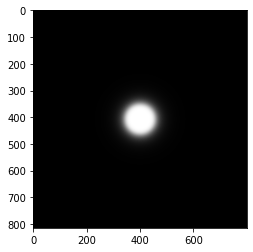

In [9]:
## Add zero padding components.
mask_bf = np.zeros_like(image) ## float32

## Apply butterworth filter.
n = 10
fc = sz

bf = lambda x, y: 1. / np.sqrt(1 + (np.sqrt(x ** 2 + y ** 2) / fc) ** n)

for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        mask_bf[i, j] = bf(i-hc, j-wc) 

plt.imshow(mask_bf, cmap="gray")

In [10]:
## Save results.
results["6"] = norm(np.abs(mfftshift)) ** .1 * mask_s
results["7"] = (norm(np.abs(mfftshift)) ** .1 * mask_s)[hc-ori_sz:hc+ori_sz, wc-ori_sz:wc+ori_sz]

results["8"] = norm(np.abs(mfftshift)) ** .1 * mask_r
results["9"] = norm(np.abs(mfftshift)) ** .1 * mask_bf

In [11]:
## Reconsult from mfftshiftcrop.
results["1"] = np.abs(np.fft.ifft2(np.fft.fftshift(mfftshift * mask_s)))
results["2"] = np.abs(np.fft.ifft2(np.fft.fftshift((mfftshift * mask_s)[hc-ori_sz:hc+ori_sz, wc-ori_sz:wc+ori_sz])))
results["3"] = np.abs(np.fft.ifft2(np.fft.fftshift(mfftshift * mask_r)))
results["4"] = np.abs(np.fft.ifft2(np.fft.fftshift(mfftshift * mask_bf)))

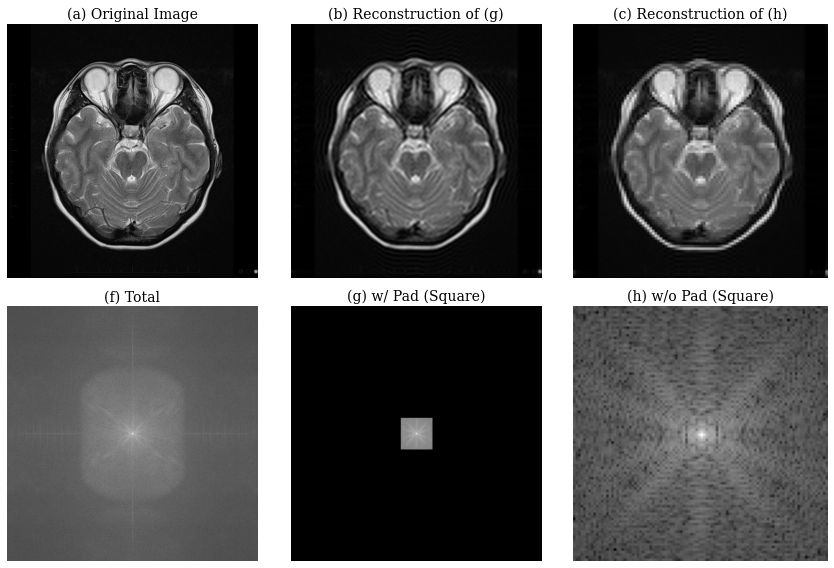

In [23]:
## Plot it.
plt.rcParams["font.family"] = "serif"

fig = plt.figure(figsize=(12, 8), facecolor="white")
titles = ["(a) Original Image", 
          "(b) Reconstruction of (g)",
          "(c) Reconstruction of (h)",
          "(d) Reconstruction of (i)",
          "(e) Reconstruction of (j)",
          "(f) Total",
          "(g) w/ Pad (Square)",
          "(h) w/o Pad (Square)",
          "(i) w/ Pad (Round)",
          "(j) w/ Pad (BW)",
          ]

for i, j in enumerate([0, 1, 2, 5, 6, 7]):
    ax = fig.add_subplot(2, 3, i + 1)
    ax.imshow(results[str(j)], cmap="gray")
    plt.title(titles[j], fontsize=14)
    ax.axis("off")

plt.tight_layout()
plt.savefig("1.png", dpi=300, transparent=True)
plt.show()

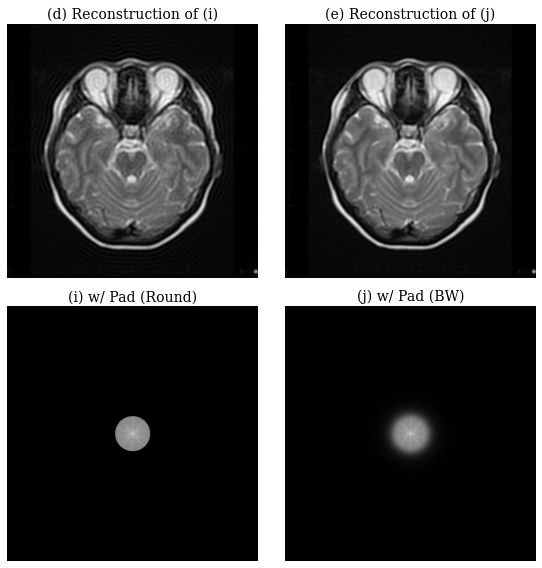

In [26]:
## Plot it.
plt.rcParams["font.family"] = "serif"

fig = plt.figure(figsize=(8, 8), facecolor="white")
titles = ["(a) Original Image", 
          "(b) Reconstruction of (g)",
          "(c) Reconstruction of (h)",
          "(d) Reconstruction of (i)",
          "(e) Reconstruction of (j)",
          "(f) Total",
          "(g) w/ Pad (Square)",
          "(h) w/o Pad (Square)",
          "(i) w/ Pad (Round)",
          "(j) w/ Pad (BW)",
          ]

for i, j in enumerate([3, 4, 8, 9]):
    ax = fig.add_subplot(2, 2, i + 1)
    ax.imshow(results[str(j)], cmap="gray")
    plt.title(titles[j], fontsize=14)
    ax.axis("off")

plt.tight_layout()
plt.savefig("2.png", dpi=300, transparent=True)
plt.show()

## **Utils**

### **3D Projection of Butterworth Filter**

In [27]:
x = np.linspace(-2*sz, 2*sz, 1000) # - hc
y = np.linspace(-2*sz, 2*sz, 1000) # - wc
x, y = np.meshgrid(x, y)

## Butterworth.
z = 1. / np.sqrt(1 + (np.sqrt(x ** 2 + y ** 2) / sz) ** n)

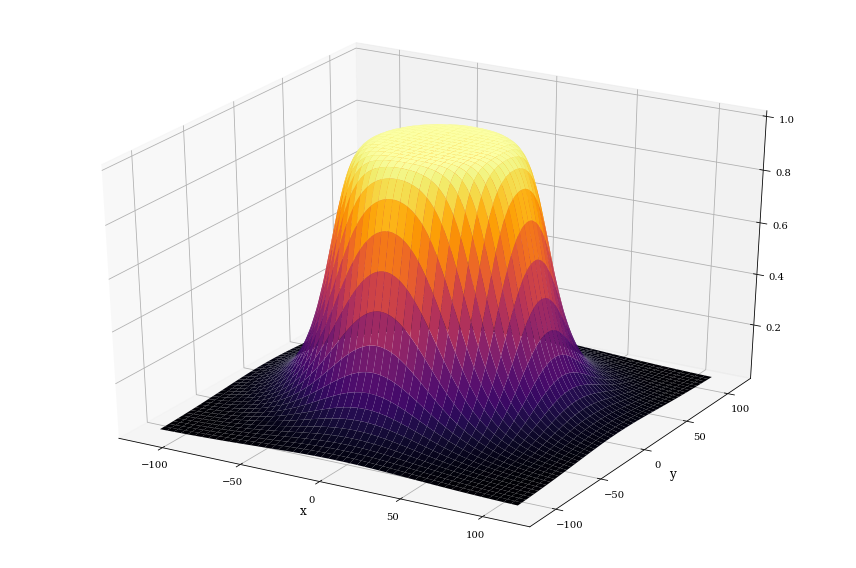

In [28]:
## Ref: https://jehyunlee.github.io/2021/07/10/Python-DS-80-mpl3d2/
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection":"3d"})

ax.plot_surface(x, y, z, cmap="inferno")
# ax.contour(x, y, z, levels=20, colors="k", linewidths=1)

ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("y", fontsize=12)
# ax.set_title(f"Butterworth Filter Applied (r={sz})", fontsize=22)

plt.grid(True, lw=.2)
plt.tight_layout()
plt.savefig("3.png", dpi=300, transparent=True)
plt.show()